
## Libraries


In [1]:
import random

# data manipulation libraries
import numpy as np
import pandas as pd

# machine learning libraries
import xgboost as xgb

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# deep learning libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap

# deployment libraries
import onnxruntime as rt
import onnxmltools
from skl2onnx.common.data_types import FloatTensorType

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU



## Parameters 


In [3]:
batch_size    = 16
learning_rate = 0.005
N_Epochs      = 1000
epsilon       = 0.0001


## Read data


In [4]:
path_data = '../data/university_admission.csv'
RAW_DATA = pd.read_csv(path_data)
RAW_DATA.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [5]:
def preprocess_data(df, unecessary_columns=[], dt_cols=[], convert_categorical=[]):
	""""Preprocess the input dataframe by dropping nan values and unecessary columns."""
	# drop nan values
	df_clean = df.dropna()
	
	# drop unecessary columns
	if unecessary_columns != []:
		df_clean = df_clean.drop(
			columns=unecessary_columns
		)
	
	if dt_cols != []:
		for col in dt_cols:
			df_clean[col] = pd.to_datetime(df_clean[col]).apply(lambda x: x.timestamp())
	
	# convert categorical columns to category dtype
	if convert_categorical != []:
		df_clean = pd.get_dummies(
			df_clean,
			columns=convert_categorical,
			drop_first=True
		)
	
	print(f"Dataframe cleaned: {df.shape[0]} -> {df_clean.shape[0]} rows")

	return df_clean

In [6]:
CLEAN_DATA = preprocess_data(
	RAW_DATA,
	unecessary_columns=['Serial No.'],
)
CLEAN_DATA.head()

Dataframe cleaned: 400 -> 400 rows


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
headers_list = CLEAN_DATA.columns.values.tolist()
headers_list

['GRE Score',
 'TOEFL Score',
 'University Rating',
 'SOP',
 'LOR ',
 'CGPA',
 'Research',
 'Chance of Admit ']

## Correlation matrix

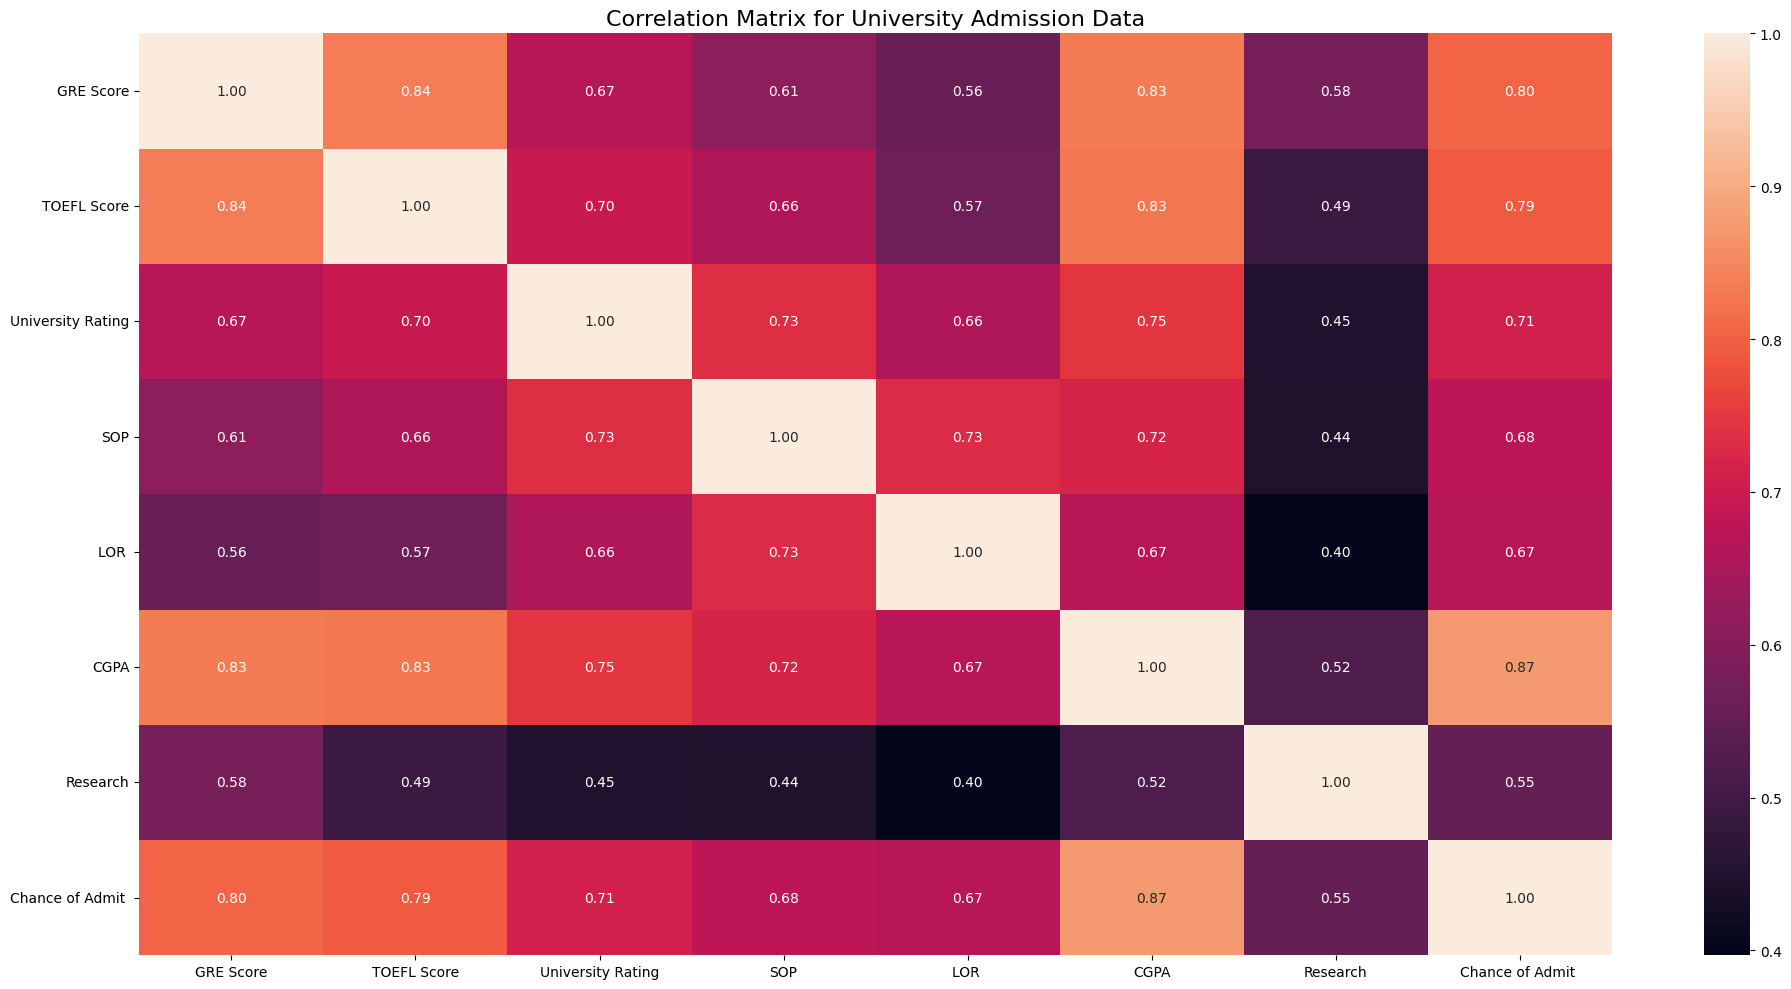

In [8]:
plt.figure(figsize=(20, 10))
sns.heatmap(CLEAN_DATA.corr(), annot=True, fmt=".2f")
plt.title("Correlation Matrix for University Admission Data", fontsize=16)
plt.tight_layout()
plt.show()


## Process Data


In [9]:
CLEAN_DATA_np = CLEAN_DATA.to_numpy()
CLEAN_DATA_np.shape, CLEAN_DATA_np

((400, 8),
 array([[337.  , 118.  ,   4.  , ...,   9.65,   1.  ,   0.92],
        [324.  , 107.  ,   4.  , ...,   8.87,   1.  ,   0.76],
        [316.  , 104.  ,   3.  , ...,   8.  ,   1.  ,   0.72],
        ...,
        [330.  , 116.  ,   4.  , ...,   9.45,   1.  ,   0.91],
        [312.  , 103.  ,   3.  , ...,   8.78,   0.  ,   0.67],
        [333.  , 117.  ,   4.  , ...,   9.66,   1.  ,   0.95]]))

In [10]:
X = CLEAN_DATA_np[:, :-1]
y = CLEAN_DATA_np[:, -1]

In [11]:
y[:5]

array([0.92, 0.76, 0.72, 0.8 , 0.65])

In [12]:
print(X.shape)
print(y.shape)

(400, 7)
(400,)


In [13]:
random_seed = int( random.random() * 100 )
random_seed

75

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [15]:
input_dim = X_train.shape[1]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(320, 7)
(80, 7)
(320,)
(80,)


In [16]:
y_test.dtype

dtype('float64')


## Fix in case float64 error


In [17]:
X_train = X_train.astype(np.float32)
X_test  = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test  = y_test.astype(np.float32)

In [18]:
X_train_tr = torch.from_numpy(X_train).to(device)
X_test_tr  = torch.from_numpy(X_test).to(device)
y_train_tr = torch.from_numpy(y_train).to(device)
y_test_tr = torch.from_numpy(y_test).to(device)


## Normalization

* Normalizartion
* Standardization (*)


In [19]:
x_means = X_train_tr.mean(0, keepdim=True)
x_deviations = X_train_tr.std(0, keepdim=True) + epsilon

In [20]:
x_means

tensor([[316.4625, 107.2812,   3.0719,   3.3781,   3.4281,   8.5858,   0.5281]],
       device='cuda:0')

In [21]:
x_deviations

tensor([[11.5499,  6.1013,  1.1466,  1.0075,  0.8992,  0.5815,  0.5001]],
       device='cuda:0')


## Create the DataLoader


In [22]:
train_ds = TensorDataset(X_train_tr, y_train_tr)
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=6,
    persistent_workers=True,
)


## Neural Network Architectures


In [23]:
class LinRegNet(nn.Module):
    """Linear Regression"""

    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(input_dim, 1)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        y_pred = self.linear1(x)
        ## return torch.round( y_pred )
        return y_pred

In [24]:
class MLP_Net(nn.Module):
    """MLP"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations

        self.linear1 = nn.Linear(input_dim, 8)
        self.act1    = nn.Sigmoid()
        self.linear2 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        y_pred = self.linear2(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [25]:
class DL_Net(nn.Module):
    """Deep Learning with 2 hidden layers"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        self.linear1 = nn.Linear(input_dim, 9)
        self.act1    = nn.ReLU()
        self.linear2 = nn.Linear(9, 6)
        self.act2    = nn.ReLU()
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        y_pred = self.linear3(x)
        
        ## return torch.round( y_pred )
        return y_pred

In [26]:
class LinearPlusNonLinear_Net(nn.Module):
    """Linear plus Nonlinear"""
    def __init__(self, x_means, x_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(input_dim, 1)
        
        ## F2
        self.f2_linear1 = nn.Linear(input_dim, 14)
        self.f2_act1    = nn.Sigmoid()
        self.f2_linear2 = nn.Linear(14, 1)
        
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_linear2(f2)
        
        y_pred = f1 + f2
        
        ## return torch.round( y_pred )
        return y_pred

## Training Loop

In [27]:
def training_loop(N_Epochs, model, loss_fn, opt):
    
    for epoch in range(N_Epochs):
        for xb, yb in train_dl:
            
            y_pred = model(xb)

            loss   = loss_fn(y_pred, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()
            
        if epoch % 20 == 0:
            print(epoch, "loss=", loss)

In [28]:
linreg_model = LinRegNet(x_means, x_deviations).to(device)

opt = torch.optim.Adam(linreg_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, linreg_model, loss_fn, opt)

C:\Users\ikath\AppData\Local\Temp\ipykernel_30356\3380744737.py:8: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss   = loss_fn(y_pred, yb)


0 loss= tensor(0.5427, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)
100 loss= tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)
120 loss= tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)
140 loss= tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)
160 loss= tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)
180 loss= tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)
200 loss= tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)
220 loss= tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)
240 loss= tensor(0.0286, device='cuda:0', grad_fn=<MseLossBackward0>)
260 loss= tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)
280 loss= tensor(0.0228, d

In [29]:
mlp_model = MLP_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(mlp_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, mlp_model, loss_fn, opt)

C:\Users\ikath\AppData\Local\Temp\ipykernel_30356\3380744737.py:8: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss   = loss_fn(y_pred, yb)


0 loss= tensor(0.5176, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)
100 loss= tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)
120 loss= tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)
140 loss= tensor(0.0350, device='cuda:0', grad_fn=<MseLossBackward0>)
160 loss= tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)
180 loss= tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)
200 loss= tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)
220 loss= tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)
240 loss= tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)
260 loss= tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)
280 loss= tensor(0.0178, d

In [30]:
dl_model = DL_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(dl_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, dl_model, loss_fn, opt)

C:\Users\ikath\AppData\Local\Temp\ipykernel_30356\3380744737.py:8: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss   = loss_fn(y_pred, yb)


0 loss= tensor(0.3557, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)
100 loss= tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)
120 loss= tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)
140 loss= tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)
160 loss= tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)
180 loss= tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)
200 loss= tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)
220 loss= tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)
240 loss= tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)
260 loss= tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)
280 loss= tensor(0.0337, d

In [31]:
mix_model = LinearPlusNonLinear_Net(x_means, x_deviations).to(device)

opt = torch.optim.Adam(mix_model.parameters(), lr=learning_rate)
loss_fn = F.mse_loss

training_loop(N_Epochs, mix_model, loss_fn, opt)

C:\Users\ikath\AppData\Local\Temp\ipykernel_30356\3380744737.py:8: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss   = loss_fn(y_pred, yb)


0 loss= tensor(0.7015, device='cuda:0', grad_fn=<MseLossBackward0>)
20 loss= tensor(0.0342, device='cuda:0', grad_fn=<MseLossBackward0>)
40 loss= tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)
60 loss= tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)
80 loss= tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)
100 loss= tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)
120 loss= tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)
140 loss= tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)
160 loss= tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)
180 loss= tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)
200 loss= tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)
220 loss= tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)
240 loss= tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)
260 loss= tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)
280 loss= tensor(0.0227, d


## Evaluate Model


In [32]:
y_pred_test_linreg = linreg_model(X_test_tr)
y_pred_test_mlp    = mlp_model(X_test_tr)
y_pred_test_dl     = dl_model(X_test_tr)
y_pred_test_mix    = mix_model(X_test_tr)

In [33]:
print( "LinReg R**2 : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_linreg.cpu().detach().numpy()))
print( "MLP R**2    : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_mlp.cpu().detach().numpy()))
print( "DL R**2     : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_dl.cpu().detach().numpy()))
print( "Mix R**2    : ", r2_score(y_test_tr.cpu().numpy(),  y_pred_test_mix.cpu().detach().numpy()))

LinReg R**2 :  0.020772457122802734
MLP R**2    :  0.04458761215209961
DL R**2     :  0.04431581497192383
Mix R**2    :  0.13311398029327393


In [34]:
# list_preds = []
# list_reals = []

# for i in range(len(X_test_tr)):
#     print("************************************")
#     print("pred, real")
#     np_real =   y_test_tr[i].detach().numpy()
#     np_pred = y_pred_test[i].detach().numpy()
#     print(( np_pred  , np_real))
#     list_preds.append(np_pred[0])
#     list_reals.append(np_real[0])


## Deploy PyTorch Model


In [35]:

# model.eval()

# dummy_input = torch.randn(1, 11)

# input_names  = ["input1"]
# output_names = ["output1"]

# torch.onnx.export(
#         model, 
#         dummy_input,
#         "DLnet_WineData.onnx",
#         verbose=False,
#         input_names = input_names,
#         output_names = output_names
        
# )
